# Предсказание цены на автомобили

Датасет содержит 10 000 записей, созданных с целью прогнозирования цен на автомобили. Каждая строка представляет информацию об автомобиле и его цене.

**Описание столбцов:**

- *Brand*: марка автомобиля.

- *Model*: модель автомобиля.

- *Year*: год выпуска.

- *Engine_Size*: размер двигателя в литрах.

- *Fuel_Type*: тип топлива, используемого автомобилем:
    - *Petrol*: автомобили, работающие на бензине.
    - *Diesel*: автомобили, работающие на дизельном топливе.
    - *Hybrid*: автомобили, использующие как топливо, так и электричество.
    - *Electric*: полностью электрические автомобили.

- *Transmission*: тип трансмиссии:
    - *Manual*: механическая коробка передач.
    - *Automatic*: автоматическая коробка передач.
    - *Semi-Automatic*: полуавтоматическая коробка передач.

- *Mileage*: общее расстояние (в км), которое проехал автомобиль.

- *Doors*: количество дверей в автомобиле.

- *Owner_Count*: количество предыдущих владельцев автомобиля.

- *Price*: цена автомобиля (таргет).

In [4]:
import optuna as opt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

sns.set_theme()

## Знакомство с данными

In [5]:
data = pd.read_csv('../data/car_price_dataset.csv')
data

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867
...,...,...,...,...,...,...,...,...,...,...
9995,Kia,Optima,2004,3.7,Diesel,Semi-Automatic,5794,2,4,8884
9996,Chevrolet,Impala,2002,1.4,Electric,Automatic,168000,2,1,6240
9997,BMW,3 Series,2010,3.0,Petrol,Automatic,86664,5,1,9866
9998,Ford,Explorer,2002,1.4,Hybrid,Automatic,225772,4,1,4084


In [6]:
# проверим данные на наличие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


In [7]:
# проверим на наличие выбросов числовые признаки
data.describe()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,2011.543700,3.000560,149239.111800,3.497100,2.991100,8852.96440
std,6.897699,1.149324,86322.348957,1.110097,1.422682,3112.59681
min,2000.000000,1.000000,25.000000,2.000000,1.000000,2000.00000
25%,2006.000000,2.000000,74649.250000,3.000000,2.000000,6646.00000
50%,2012.000000,3.000000,149587.000000,3.000000,3.000000,8858.50000
75%,2017.000000,4.000000,223577.500000,4.000000,4.000000,11086.50000
max,2023.000000,5.000000,299947.000000,5.000000,5.000000,18301.00000


## EDA

In [8]:
# взглянем на статистику категориальных данных
data.describe(include=['object'])

,Brand,Model,Fuel_Type,Transmission
count,10000,10000,10000,10000
unique,10,30,4,3
top,Ford,Accord,Electric,Manual
freq,1048,365,2625,3372


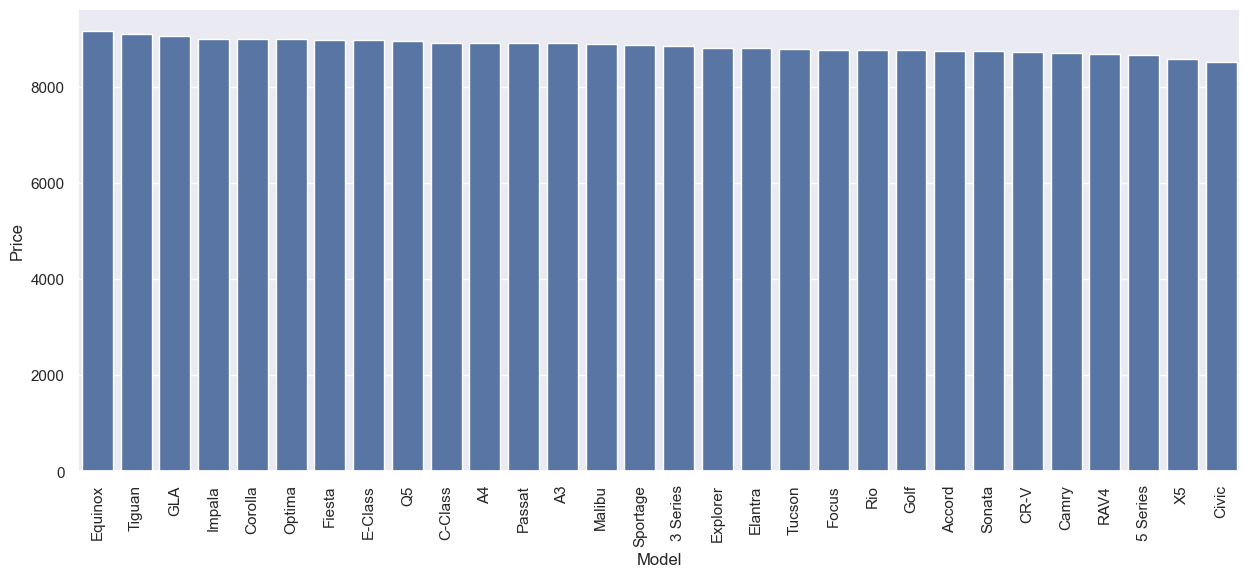

Среднеквадратическое отклонение: 149.3297740854194


In [9]:
# взглянем, как модель влияет на ценообразование
price_by_model = data.groupby('Model')['Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(price_by_model)
plt.xticks(rotation=90)
plt.show()
print('Среднеквадратическое отклонение:', price_by_model.std())

## Подготовка данных

In [10]:
# закодируем порядковые признаки
ord_encoder = LabelEncoder()

data['Doors'] = ord_encoder.fit_transform(data['Doors'])
data['Owner_Count'] = ord_encoder.fit_transform(data['Owner_Count'])

In [11]:
# закодируем номинальные признаки one hot encoding
columns_encode = ['Brand', 'Model', 'Year', 'Fuel_Type', 'Transmission']

data = pd.get_dummies(data, columns=columns_encode, drop_first=True, dtype='int')

In [12]:
# подготовим тренировочную и тестовую выборки
X = data.drop(['Price'], axis=1)
y = data['Price']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

In [13]:
# нормализуем числовые признаки с помощию minmaxscaler
num_columns = ['Engine_Size', 'Mileage']

scaler = MinMaxScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

## Обучение модели

In [14]:
# в качестве модели регрессии используем RandomForest
forest = RandomForestRegressor(
    n_estimators=500,
    criterion='squared_error',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)

forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=500,
                      random_state=42)

## Оценка модели

In [15]:
print('MAE:', mean_absolute_error(y_test, forest.predict(X_test)))
print('R^2:', r2_score(y_test, forest.predict(X_test)))

MAE: 1252.9066937308517
R^2: 0.7427558743552776


## Подбор гиперпараметров

In [ ]:
# подберем оптимальные гиперпараметры для нашей модели с помощью optuna и кросс-валидации
def opt_forest(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 10, 30, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)
    
    model = RandomForestRegressor(
        n_estimators=500,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=42
    )
    
    score = cross_val_score(
        model, X_train, y_train,
        scoring='r2',
        cv=5,
        n_jobs=-1
    ).mean()
    
    return score

In [ ]:
forest_study = opt.create_study(study_name='RandomForest', direction='maximize')
forest_study.optimize(opt_forest, n_trials=8, n_jobs=-1)

[I 2025-02-28 12:35:31,282] A new study created in memory with name: RandomForest
[I 2025-02-28 12:37:14,257] Trial 0 finished with value: 0.8813829595910739 and parameters: {'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8813829595910739.
[I 2025-02-28 12:38:37,179] Trial 5 finished with value: 0.8006355817046262 and parameters: {'criterion': 'poisson', 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8813829595910739.
[I 2025-02-28 12:39:22,018] Trial 3 finished with value: 0.8006872034637975 and parameters: {'criterion': 'squared_error', 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8813829595910739.
[I 2025-02-28 12:42:21,386] Trial 1 finished with value: 0.7918508869923311 and parameters: {'criterion': 'squared_error', 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8813829595910739.
[I 2025-02-28 12:43:17,269] Trial 8 finished with value: 0.8309253327250138 and 

In [ ]:
print('Best params:', forest_study.best_params)

Best params: {'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 2}


In [17]:
forest = RandomForestRegressor(
    **{'criterion': 'poisson', 'max_depth': 20, 'min_samples_leaf': 2},
    n_estimators=500,
    random_state=42
)

forest.fit(X_train, y_train)

print('MAE:', mean_absolute_error(y_test, forest.predict(X_test)))
print('R^2:', r2_score(y_test, forest.predict(X_test)))

MAE: 752.6497822095231
R^2: 0.891472333762128
